In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
import nltk
import string

In [2]:
import pandas as pd
import io
from google.colab import files

In [3]:
url = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [4]:
data = pd.read_csv(url)

In [5]:
data.head()

id  ... label
0   8476  ...  FAKE
1  10294  ...  FAKE
2   3608  ...  REAL
3  10142  ...  FAKE
4    875  ...  REAL

[5 rows x 4 columns]

In [6]:
len(data)

6335

In [ ]:
import nltk

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Let's take a look at Real News

In [ ]:
data

id  ... label
0      8476  ...  FAKE
1     10294  ...  FAKE
2      3608  ...  REAL
3     10142  ...  FAKE
4       875  ...  REAL
...     ...  ...   ...
6330   4490  ...  REAL
6331   8062  ...  FAKE
6332   8622  ...  FAKE
6333   4021  ...  REAL
6334   4330  ...  REAL

[6335 rows x 4 columns]

are there any missing values in `News.csv`?

In [ ]:
data.isna().sum()

id       0
title    0
text     0
label    0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

In [ ]:
# don't forget to shuffle them. 
# Otherwise all news are on top and all fakes are on the bottom
data = data.sample(frac=1)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

For this notebook, I will ignore the `dates` and `subjects`(because they are disjoint). I will probably take a look at them in a later project. Let's drop them for now.

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.head()

id  ... label
3736  7213  ...  FAKE
5867   799  ...  REAL
1631   698  ...  REAL
4425  8335  ...  FAKE
2487   362  ...  REAL

[5 rows x 4 columns]

Are there any duplicates in the data? If yes, we would have to remove them

In [ ]:
data = data.drop(['id'], axis=1)


# ***Replace label with numeric values*** **bold text**

In [ ]:
data = data.replace(to_replace ="FAKE",
                 value =1)



In [ ]:
data = data.replace(to_replace ="REAL",
                 value =0)


Before taking a closer look at the data, perform a `train_test_split` to evade **Data Snooping**!

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,random_state=42)
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

In [ ]:
X_train.head()

title                                               text
2803  Pro-Lifers Take over Planned Parenthood's #PPS...  Pro-lifers have taken to social media to use P...
259   'You've been fleeced': Congress grills Kerry, ...  Secretary of State John Kerry found himself on...
4843  Watch: Praying Muslims sit on Jewish prayer sh...  Jews in Ben Gurion Airport were dismayed to di...
2320  Canada Posts Perfect Tweet After Immigration W...  While the United States sits on the edge of it...
2794                                     Coming Unglued  By John Kaminski on October 30, 2016 John Kami...

how are Fake News distributed among the train and the test data?

In [ ]:
y_train.value_counts()

1    2398
0    2353
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

0    818
1    766
Name: label, dtype: int64

# Inspect the Training data to get further insights
Therefore we have to split the Training set into News and Fake News

In [ ]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

## Lexical Diversity of Fake News
Let's define a measure for lexical diversity to find out how many unique vocabs are used in Fake News articles.

Let's define the lexical diversity measure as $\frac{\text{number of unique words in one (target)category}}{\text{number of words in both (target)categories}}$

In [ ]:
# a very simple measure for lexical diversity
def lexical_diversity(data, other_data, feature):
    # ignoare capital letters
    column = data[feature].str.lower() 
    # create one text from the column
    text = ' '.join(column)
    # drop punctuation
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    # create a list of wordsw instead of one huge text
    words_splitted = words.split()
    
    # analogously
    other_column = other_data[feature].str.lower() 
    other_text = ' '.join(other_column)
    other_words = ''.join(char for char in other_text if char not in exclude)
    other_words_splitted = other_words.split()
    # lexical diversity measure
    return len(set(words_splitted)) / (len(words_splitted) + len(other_words_splitted))

print(f'Real News: {lexical_diversity(data=train_news, other_data=train_fake, feature="text")}')
print(f'Fake News: {lexical_diversity(data=train_fake, other_data=train_news, feature="text")}')

Real News: 0.015809037916793157
Fake News: 0.018773573779514316


Interestingly it seems like `Fake News` contain almost two times greater lexical diversity than real news. Their authors seem to have a wide vocabulary.

## Most frequently used words in Titles
is there a difference between the most frequently used words in the titles of Real News and Fake News? This question might already reveal the topics of the Fake News articles.

In [ ]:
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'title', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'title', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0      trump
1    clinton
2      obama
3        gop
4     donald
5    hillary
6     debate
7        new
8       2016
9         us
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0       trump
1     hillary
2     clinton
3          us
4           –
5    election
6         new
7         fbi
8       video
9        news
Name: 0, dtype: object


It seems like most Fake News Articles in our Training data are about US Presidents and candidates for the latter. Besides `trump`, the real news seem to focus on more general political topics.

# Punctutation
Punctuation might provide some information for predictions. 

In [ ]:
import regex as re

# let's begin with a helper function to count punctuation
def count_punctuation(text):
    peri = re.subn(r"\.", '', text)[1]
    comm = re.subn(r"\,", '', text)[1]
    ques = re.subn(r"\?", '', text)[1]
    excl = re.subn(r"\!", '', text)[1]
    return [peri,comm, ques, excl]
    
count_punctuation('...alph!a.beta.gamma...??')

[8, 0, 2, 1]

In [ ]:
# count the usage of puntuations per row in a specified feature (title and text)
# and store the data in a dataframe
def create_punctuation_df(dataset, feature):
    return dataset.apply(lambda row: pd.Series({'peri_' + feature:count_punctuation(row[feature])[0], 
                                                       'comm_' + feature:count_punctuation(row[feature])[1],
                                                      'ques_' + feature:count_punctuation(row[feature])[2],
                                                      'excl_' + feature:count_punctuation(row[feature])[3]}), axis=1)

punctuation_train_title = create_punctuation_df(train, 'title')
punctuation_test_title = create_punctuation_df(test, 'title')
punctuation_train_text = create_punctuation_df(train, 'text')
punctuation_test_text = create_punctuation_df(test, 'text')
punctuation_train_text 

peri_text  comm_text  ques_text  excl_text
2803         43         23         15          1
259          49         51          0          0
4843          3          1          0          0
2320         20         19          2          0
2794         92         65         12          0
...         ...        ...        ...        ...
5981         56         40          3          1
1540         45         48          0          0
831          69         68          2          2
5374          6          3          0          0
5225         20         28          0          0

[4751 rows x 4 columns]

# Text Length

In [ ]:
# count the text length per row for both features (title and text)
# and store the information in a dataframe
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({'length_title':len(row['title']),
                                               'length_text':len(row['text'])}), axis=1)

len_train = create_len_df(train)
len_test = create_len_df(test)

len_train

length_title  length_text
2803            59         3169
259             79         5615
4843            86          403
2320            60         2177
2794            14        11039
...            ...          ...
5981            20         5426
1540            59         4921
831            118         8331
5374            71          584
5225            36         3050

[4751 rows x 2 columns]

## Number of Words in the Title
Let's create a feature which counts the number of words in the Title. In my **Digital Markeeting Courses** I learned, that titles are extremely important when it comes to grabbing Attention. A rule of thumbs tells us that titles should have about 5 words.

In [ ]:
def create_num_words_df(dataset):
    return dataset.apply(lambda row: pd.Series({'num_words_title':len(row['title'].split())}), axis=1)

num_words_train = create_num_words_df(train)
num_words_test = create_num_words_df(test)

num_words_train

num_words_title
2803                6
259                12
4843               15
2320                8
2794                2
...               ...
5981                4
1540               12
831                17
5374               10
5225                5

[4751 rows x 1 columns]

## Lenght of Title Relative to the Length of the Article + Title
One could assume that some attention grabbing Fake News have a long title and very short texts. Is that true?

In [ ]:
def create_title_ratio_df(dataset):
    return dataset.apply(lambda row: pd.Series({'title_ratio':len(row['title'])/(len(row['title']) + len(row['text']))}), axis=1)

title_ratio_train = create_title_ratio_df(train)
title_ratio_test = create_title_ratio_df(test)

title_ratio_train

title_ratio
2803     0.018278
259      0.013874
4843     0.175869
2320     0.026822
2794     0.001267
...           ...
5981     0.003672
1540     0.011847
831      0.013966
5374     0.108397
5225     0.011666

[4751 rows x 1 columns]

## Concatenate the new Datasets

In [ ]:
X_train_punct_len = pd.concat([punctuation_train_title, 
                               punctuation_train_text, 
                               len_train, 
                               num_words_train, 
                               title_ratio_train], 
                              axis=1)

X_test_punct_len = pd.concat([punctuation_test_title, 
                              punctuation_test_text, 
                              len_test, 
                              num_words_test, 
                              title_ratio_test], 
                             axis=1)

X_train_punct_len

peri_title  comm_title  ...  num_words_title  title_ratio
2803           0           0  ...                6     0.018278
259            0           1  ...               12     0.013874
4843           0           0  ...               15     0.175869
2320           0           0  ...                8     0.026822
2794           0           0  ...                2     0.001267
...          ...         ...  ...              ...          ...
5981           0           0  ...                4     0.003672
1540           0           0  ...               12     0.011847
831            0           0  ...               17     0.013966
5374           0           0  ...               10     0.108397
5225           0           0  ...                5     0.011666

[4751 rows x 12 columns]

## **Let's clean the data and add sentiment features**




In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Data Cleaning

In [ ]:
X_sentiment_train = X_train
X_sentiment_test = X_test

In [ ]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
        # join all
    text = " ".join(text)
    return(text)

# clean text data
X_sentiment_train['text'] = X_sentiment_train['text'].apply(lambda x: clean_text(x))
X_sentiment_test['text'] = X_sentiment_test['text'].apply(lambda x: clean_text(x))

In [ ]:
X_sentiment_train['text']

2803    pro-lifer take social medium use plan parentho...
259     secretary state john kerry find defensive thur...
4843    jew ben gurion airport dismay discover turkish...
2320    united state sits edge collective seat donald ...
2794    john kaminski october john kaminski rebel.org ...
                              ...                        
5981    god choose trump \n\ntrump cannot win american...
1540    new video al shabaab purportedly show terror g...
831     home change state sheriff say cannabis make pe...
5374    print \n[ed well that’s new one \na man custod...
5225    michelle obama promote lewd rappers\nfrom gera...
Name: text, Length: 4751, dtype: object

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_train['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_train = pd.DataFrame(list(sentiment_scores))

sentiment_scores = X_sentiment_test['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_test = pd.DataFrame(list(sentiment_scores))


In [ ]:
sent_scores_train

neg    neu    pos  compound
0     0.149  0.689  0.162   -0.3555
1     0.090  0.769  0.141    0.9828
2     0.101  0.721  0.178    0.5106
3     0.025  0.727  0.248    0.9933
4     0.257  0.574  0.170   -0.9992
...     ...    ...    ...       ...
4746  0.208  0.628  0.164   -0.9893
4747  0.193  0.712  0.095   -0.9966
4748  0.309  0.581  0.110   -0.9998
4749  0.185  0.786  0.029   -0.8519
4750  0.157  0.682  0.161    0.0772

[4751 rows x 4 columns]

In [ ]:
sent_scores_train.index = X_train_punct_len.index
sent_scores_test.index = X_test_punct_len.index

In [ ]:
sent_scores_train

neg    neu    pos  compound
2803  0.149  0.689  0.162   -0.3555
259   0.090  0.769  0.141    0.9828
4843  0.101  0.721  0.178    0.5106
2320  0.025  0.727  0.248    0.9933
2794  0.257  0.574  0.170   -0.9992
...     ...    ...    ...       ...
5981  0.208  0.628  0.164   -0.9893
1540  0.193  0.712  0.095   -0.9966
831   0.309  0.581  0.110   -0.9998
5374  0.185  0.786  0.029   -0.8519
5225  0.157  0.682  0.161    0.0772

[4751 rows x 4 columns]

In [ ]:
X_train_punct_len['negative'] = sent_scores_train['neg'].values
X_train_punct_len['positive'] = sent_scores_train['pos'].values
X_train_punct_len['neutral'] = sent_scores_train['neu'].values


X_test_punct_len['negative'] = sent_scores_test['neg'].values
X_test_punct_len['positive'] = sent_scores_test['pos'].values
X_test_punct_len['neutral'] = sent_scores_test['neu'].values

# Investigate the Engineered Features

In [ ]:
X_train_punct_len.head()

peri_title  comm_title  ques_title  ...  negative  positive  neutral
2803           0           0           0  ...     0.149     0.162    0.689
259            0           1           0  ...     0.090     0.141    0.769
4843           0           0           0  ...     0.101     0.178    0.721
2320           0           0           0  ...     0.025     0.248    0.727
2794           0           0           0  ...     0.257     0.170    0.574

[5 rows x 15 columns]

* Many Titles don't contain any form of `punctuation`!

* Some texts contain suspiciously small amounts of characters. At least one of them contains only 1 chars

Let's remove some extreme outliers!

In [ ]:
from scipy import stats
X_train_punct_len_zscore = X_train_punct_len.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_punct_len_zscore>5).any(axis=1)).values + ((X_train_punct_len_zscore<-5).any(axis=1)).values)
X_train_punct_len = X_train_punct_len.loc[mask_outliers,:]
y_train = y_train[X_train_punct_len.index]

How does our data look like now?

In [ ]:
X_train_punct_len.describe()

peri_title   comm_title  ...     positive      neutral
count  4751.000000  4751.000000  ...  4751.000000  4751.000000
mean      0.132183     0.236371  ...     0.140373     0.733917
std       0.481880     0.526269  ...     0.065521     0.102960
min       0.000000     0.000000  ...     0.000000     0.000000
25%       0.000000     0.000000  ...     0.102000     0.685500
50%       0.000000     0.000000  ...     0.137000     0.737000
75%       0.000000     0.000000  ...     0.178000     0.787500
max       7.000000     7.000000  ...     0.546000     1.000000

[8 rows x 15 columns]

## How do they interact with each other?

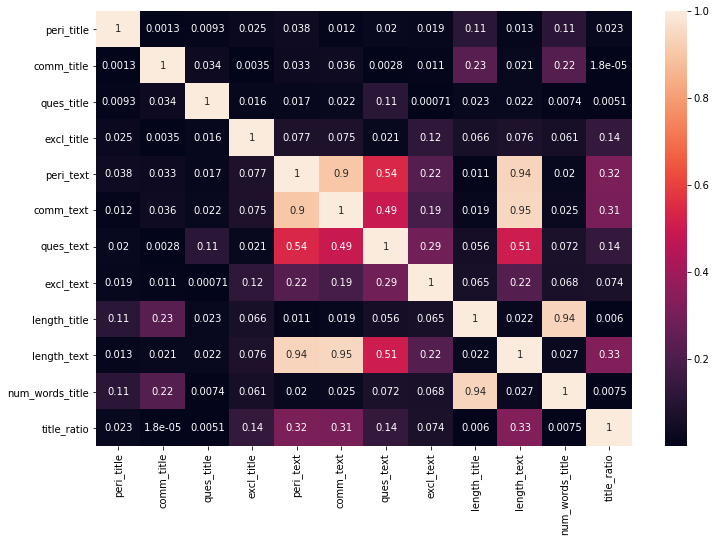

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(np.abs(X_train_punct_len.corr()), annot=True)
plt.savefig('correlation')
plt.show()

* huge correlation between `peri_text` and `length_text`

* huge correlation between `comm_text` and `length_text`

* huge correlation between `comm_text` and `peri_text`

* huge correlation between `peri_test` and `num_words_text`

...and so on

We have to find out how they interact with the target to determine what to do with them.

## How do they Interact with the Target?

In [ ]:
pd.concat([X_train_punct_len, y_train], axis=1).groupby('label').mean()

peri_title  comm_title  ...  num_words_title  title_ratio
label                          ...                              
0        0.136422    0.259669  ...         9.886953     0.036872
1        0.128023    0.213511  ...        11.149291     0.058478

[2 rows x 12 columns]

**Main Findings:**
* Titles of Fake News contain ~4 times less `periods`

* Titles of Fake News contain ~10 times more `question marks`

* Titles of Fake News contain ~130 times more `exclamation marks` **(wow!)**

* Texts of Fake News contain ~10 times more `question marks` 

* Texts of Fake News contain ~10 times more `exclamation marks`

* Titles of Fake News are 50% `longer`. The number of words seems to reflect that fact as well. -> The length of words in the titles of Fake News and real News don't seem to vary a lot.

* $\frac{len(title)}{len(title) + len(text)}$ is ~40% longer in Fake News

* Let's ignore the high correlations we found above. A more elaborate approach would be to eliminate correlating features by dropping them or using dimensionality reduction like PCA

# Apply Naive Bayes( ACC: 63%)

In [ ]:
# Naive Bayes Model
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [ ]:
nb = MultinomialNB()
nb.fit(X_train_punct_len, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
preds_test = nb.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.6513545347467609
acc: 0.6262626262626263


In [ ]:
confusion_matrix(y_test, preds_test)

array([[439, 379],
       [213, 553]])

# Logistic Regression ( 69%)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train the model
lr = LogisticRegression()
lr.fit(X_train_punct_len, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds_test = lr.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.7060255629945221
acc: 0.6950757575757576


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
confusion_matrix(y_test, preds_test)

array([[521, 297],
       [186, 580]])

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds_test, labels=[0, 1]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, preds_test, labels=[0, 1]))

[[521 297]
 [186 580]]
              precision    recall  f1-score   support

           0       0.74      0.64      0.68       818
           1       0.66      0.76      0.71       766

    accuracy                           0.70      1584
   macro avg       0.70      0.70      0.69      1584
weighted avg       0.70      0.70      0.69      1584



# Random Forest
Let's use a default RandomForest for our classification!

In [ ]:

from sklearn.ensemble import RandomForestClassifier
# Train the model
rf = RandomForestClassifier()
rf.fit(X_train_punct_len, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds_test = rf.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.7296587926509187
acc: 0.73989898989899


In [ ]:
confusion_matrix(y_test, preds_test)

array([[620, 198],
       [208, 558]])

# A Simple Model based on Punctuation and Text Length
Let's use a default RandomForest for our classification!

Interestingly, the length of the title is way more important than e.g. `excl_title`, even though the relation between the target and `excl_title` is way stronger. This is most likely the case because only a few titles contain exclamation marks.

## Finetune the model

In [ ]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[200, 300],
        'criterion':['gini', 'entropy'],
        'max_depth':[5, None],
        'max_features':[2,5]}
gscv = GridSearchCV(rf, params)
gscv.fit(X_train_punct_len, y_train)
gscv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 2,
 'n_estimators': 300}

In [ ]:
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=None, max_features=2, n_estimators=200, random_state=42)
preds = cross_val_predict(rf_tuned, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.7365534697321241
acc: 0.7442146221585091


In [ ]:
rf_tuned.fit(X_train_punct_len, y_train)
pd.Series(rf_tuned.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_text        0.123547
peri_text          0.115648
title_ratio        0.114766
comm_text          0.099925
length_title       0.092310
negative           0.091638
neutral            0.087135
positive           0.087016
num_words_title    0.066934
ques_text          0.043973
excl_text          0.036169
comm_title         0.015585
peri_title         0.010413
ques_title         0.007554
excl_title         0.007388
dtype: float64

## Final Prediction on Test

In [ ]:
X_sentiment_test['text'] = X_sentiment_test['text'].apply(lambda x: clean_text(x))

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_test['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_test = pd.DataFrame(list(sentiment_scores))


In [ ]:
sent_scores_test.head()

neg    neu    pos  compound
0  0.122  0.780  0.098   -0.6546
1  0.204  0.659  0.138   -0.9776
2  0.153  0.800  0.047   -0.9201
3  0.198  0.688  0.114   -0.9953
4  0.236  0.688  0.076   -0.9997

In [ ]:
sent_scores_test.index = X_test_punct_len.index

In [ ]:
X_test_punct_len['negative'] = sent_scores_test['neg'].values
X_test_punct_len['positive'] = sent_scores_test['pos'].values
X_test_punct_len['neutral'] = sent_scores_test['neu'].values

In [ ]:
X_test_punct_len.head()

peri_title  comm_title  ques_title  ...  negative  positive  neutral
506            0           0           0  ...     0.055     0.089    0.856
377            0           0           0  ...     0.116     0.176    0.708
4405           0           0           0  ...     0.144     0.100    0.756
2817           0           0           0  ...     0.109     0.171    0.720
5505           0           0           0  ...     0.000     0.242    0.758

[5 rows x 15 columns]

In [ ]:
preds_test = rf_tuned.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.726672171758877
acc: 0.7387529597474349


`f1-score` of about 93%! Our model is already very powerful, even though it solely focuses on punctuation and text length. Moreover, it performs even better than on train!

# How well can we predict on subsets of the Features?

In [ ]:
forest = RandomForestClassifier(random_state=42)

best_column = 'all'
best_score = 0
for column in X_train_punct_len.columns:
    forest.fit(X_train_punct_len[column].values.reshape((-1,1)), y_train)
    preds = cross_val_predict(forest, X_train_punct_len[column].values.reshape((-1,1)), y_train, cv=5)
    f1 = f1_score(y_true=y_train, y_pred=preds)
    
    if(f1>best_score):
        best_score = f1
        best_column = column

print(f'A default RandomForest already obtains an f1-score of {f1} on validation data when trained solely on the column {column}')

A default RandomForest already obtains an f1-score of 0.38525014949172814 on validation data when trained solely on the column neutral


In [ ]:
forest = RandomForestClassifier(random_state=42)
punctuation = ['peri_title', 'comm_title', 'ques_title', 'excl_title', 'peri_text', 'comm_text', 'ques_text', 'excl_text']
lenght = ['length_title', 'length_text','num_words_title', 'title_ratio']


forest.fit(X_train_punct_len[punctuation], y_train)
preds = cross_val_predict(forest, X_train_punct_len[punctuation], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on punctuation-based Features')
print('The Feature Inportances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=punctuation).sort_values(ascending=False))

forest.fit(X_train_punct_len[lenght], y_train)
preds = cross_val_predict(forest, X_train_punct_len[lenght], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on length-based Features')
print('The Feature Importances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=lenght).sort_values(ascending=False))

A default RandomForest already obtains an f1-score of 0.7467359208794336 when trained solely on punctuation-based Features
The Feature Inportances in that approach are:
ques_text     0.280368
comm_text     0.209380
peri_text     0.205038
excl_text     0.129412
peri_title    0.087740
excl_title    0.074116
comm_title    0.013946
ques_title    0.000000
dtype: float64
A default RandomForest already obtains an f1-score of 0.8499982896042144 when trained solely on length-based Features
The Feature Importances in that approach are:
length_title       0.404039
title_ratio        0.208556
length_text        0.197260
num_words_title    0.190145
dtype: float64


As we saw, even some basic feature engineering might reveal powerful features for our machine learning models. I am pretty sure that adding `Word Embeddings` will improve the performance by a lot.

Thank you for reading this notebook!